In [1]:
## Keras for deep learning
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional
from keras.models import Sequential

## Scikit learn for mapping metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
#for logging
import time

##matrix math
import math

##plotting
import matplotlib.pyplot as plt
from sklearn import preprocessing

import pandas as pd
import os
import numpy as np
import time
import datetime

##matrix math
import math


os.chdir('D:/Graduate Courses/2019 Dissertation/Data/Other.coins')
print("Current Working Directory " , os.getcwd())

Using TensorFlow backend.


Current Working Directory  D:\Graduate Courses\2019 Dissertation\Data\Other.coins


In [2]:
# %load SM
#!/usr/bin/env python

# In[ ]:


#load the data
def load_data(filename, window_length,percent):
    """
    Loads the bitcoin data
    
    Arguments:
    filename -- A string that represents where the .csv file can be located
    sequence_length -- An integer of how many days should be looked at in a row
    
    Returns:
    if window=30
    X_train -- A tensor of shape (2492, 30, 105) that will be inputed into the model to train it
    Y_train -- A tensor of shape (2492,) that will be inputed into the model to train it
    X_test -- A tensor of shape (623, 30, 105) that will be used to test the model's proficiency
    Y_test -- A tensor of shape (623,) that will be used to check the model's predictions
    Y_daybefore -- A tensor of shape (623,) that represents the price of bitcoin the day before each Y_test value
    """
    
    #Read the data file
    dataset_total = pd.read_csv(filename,na_values='n/a',parse_dates=['Date'])
    dataset_total=dataset_total.drop(['Unnamed: 0',], axis=1)

    # Set index
    dataset_total.set_index('Date', inplace=True)
    dataset_total= dataset_total.loc[:, (dataset_total!= 0).any(axis=0)]

    #normalize dataset
    from sklearn.preprocessing import MinMaxScaler
    sc = MinMaxScaler(feature_range = (0, 1))
    dataset_total_scaled = sc.fit_transform(dataset_total)
    X_normal=dataset_total_scaled[:,:-1]
    Y=dataset_total_scaled[:,-1]
    
   
    #Convert the data to a 3D array (a x b x c) 
    #Where a is the number of days, b is the window size, and c is the number of features in the data file
    data = X_normal.tolist()
    result = []
    for index in range(len(data) - window_length):
        result.append(data[index: index + window_length])

    data_reshape=np.array(result)
    data_reshape.shape

    #Splitting data set into training (First 80% of data points) and testing data (last 20% of data points)
    split_line = round(percent * data_reshape.shape[0])
    X_train = data_reshape[:int(split_line), :]
    Y_train = Y[window_length:int(split_line)+window_length]
    X_test = data_reshape[int(split_line):,:]
    Y_test = Y[int(split_line)+window_length:]
    Y_daybefore = Y[int(split_line)+window_length-1:-1]
    return X_train, Y_train, X_test, Y_test, window_length,dataset_total,Y_daybefore

def initialize_model(dropout_rate):
    """
    Initializes and creates the model to be used
    
    Arguments:
    dropout_rate -- A decimal representing how much dropout should be incorporated at each level, in this case 0.2
    activation_function -- A string to define the activation_function, in this case it is linear
    loss_function -- A string to define the loss function to be used, in the case it is mean squared error
    optimizer -- A string to define the optimizer to be used, in the case it is adam
    
    Returns:
    model -- A 3 layer RNN with 100*dropout_value dropout in each layer that uses activation_function as its activation
             function, loss_function as its loss function, and optimizer as its optimizer
    """
  
    #Build the model
    model=Sequential()

    input_shape=(window_length, X_train.shape[-1])

    optimizer='adam'
    loss='mean_squared_error'
    
    model.add(LSTM(units = 32, return_sequences = True, input_shape = input_shape))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units = 32, activation='relu'))
    
    
    model.add(LSTM(units = 32, return_sequences = True))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units = 32, activation='relu'))
    
    model.add(LSTM(units = 32, return_sequences = False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units = 1,activation='linear'))
   
    
              
    model.compile(optimizer =optimizer, loss = loss)

    
    return model

#Training the model

def fit_model(model, X_train, Y_train, batch_num, num_epoch, val_split):
    """
    Fits the model to the training data
    
    Arguments:
    model -- The previously initalized 3 layer Recurrent Neural Network
    X_train -- A tensor of shape (2492, 30, 105) that represents the x values of the training data
    Y_train -- A tensor of shape (2492,) that represents the y values of the training data
    batch_num -- An integer representing the batch size to be used, in this case 100
    num_epoch -- An integer defining the number of epochs to be run, in this case 100
    val_split -- A decimal representing the proportion of training data to be used as validation data
    
    Returns:
    model -- The 3 layer Recurrent Neural Network that has been fitted to the training data
    training_time -- An integer representing the amount of time (in seconds) that the model was training
    """
   

    #Train the model on X_train and Y_train
    model.fit(X_train, Y_train, batch_size= batch_num, nb_epoch=num_epoch, validation_split= val_split)

    return model

# test the model
def test_model(model, X_test, Y_test):
    """
    Test the model on the testing data
    
    Arguments:
    model -- The previously fitted 3 layer Recurrent Neural Network
    X_test -- A tensor of shape (623, 30, 105) that represents the x values of the testing data
    Y_test -- A tensor of shape (623,) that represents the y values of the testing data
    unnormalized_bases -- A tensor of shape (623,) that can be used to get unnormalized data points
    
    Returns:
    y_predict -- A tensor of shape (623,) that represnts the normalized values that the model predicts based on X_test
    real_y_test -- A tensor of shape (623,) that represents the actual prices of bitcoin throughout the testing period
    real_y_predict -- A tensor of shape (623,) that represents the model's predicted prices of bitcoin
    fig -- A branch of the graph of the real predicted prices of bitcoin versus the real prices of bitcoin
    """
    #Test the model on X_Test
    Y_norm = model.predict(X_test)
    
    # normalize predicted y
    Y_original=dataset_total.iloc[:,-1]
    Y_max=Y_original.max()
    Y_min=Y_original.min()
    real_y_predict = Y_norm *(Y_max-Y_min)+Y_min
    
    # normalize Y_test
    real_y_test = Y_test *(Y_max-Y_min)+Y_min
    
    # normalize real Y_daybefore
    real_y_daybefore = Y_daybefore * (Y_max-Y_min)+Y_min

    #Plot of the predicted prices versus the real prices
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    ax.set_title("EOS Return Over Time")
    plt.plot(real_y_predict, color = 'green', label = 'Predicted Return')
    plt.plot(real_y_test, color = 'red', label = 'Real Return')
    ax.set_ylabel("Return")
    ax.set_xlabel("Time (Days)")
    ax.legend()
    
    return Y_norm, real_y_test, real_y_predict, fig, real_y_daybefore

#evaluate change in return

def return_change(real_y_daybefore, real_y_test, real_y_predict):
    """
    Calculate the percent change between each value and the day before
    
    Arguments:
    real_y_daybefore -- A tensor of shape (623,) that represents the prices of each day before each price in Y_test
    Y_test -- A tensor of shape (623,) that represents the normalized y values of the testing data
    y_predict -- A tensor of shape (623,) that represents the normalized y values of the model's predictions
    
    Returns:
    delta_predict -- A tensor of shape (623, ) that represents the difference between predicted and day before values
    delta_real -- A tensor of shape (623, ) that represents the difference between real and day before values
    fig -- A plot representing percent change in bitcoin price per day,
    """
    return_change_real = real_y_test - real_y_daybefore
    real_y_predict_reshape= np.reshape(real_y_predict,(real_y_predict.shape[0],))
    return_change_predict = real_y_predict_reshape - real_y_daybefore

    fig_2 = plt.figure(figsize=(10, 6))
    ax = fig_2.add_subplot(111)
    ax.set_title("Change in EOS Return Per Day")
    plt.plot(return_change_predict, color='green', label = 'Predicted Return Change')
    plt.plot(return_change_real, color='red', label = 'Real Return Change')
    plt.ylabel("Return Change")
    plt.xlabel("Time (Days)")
    ax.legend()
    plt.show()
    return  return_change_predict, return_change_real, fig_2

def binary_return(return_change_predict,return_change_real):
    """
    Converts return change to a binary 1 or 0, where 1 is an increase and 0 is a decrease/no change
    
    Arguments:
    delta_predict -- A tensor of shape (623, 1) that represents the predicted percent change in price
    delta_real -- A tensor of shape (623, 1) that represents the real percent change in price
    
    Returns:
    delta_predict_1_0 -- A tensor of shape (623, 1) that represents the binary version of delta_predict
    delta_real_1_0 -- A tensor of shape (623, 1) that represents the binary version of delta_real
    """
    #Empty arrays where a 1 represents an increase in price and a 0 represents a decrease in price
    return_change_predict_1_0 = np.empty(return_change_predict.shape)
    return_change_real_1_0 = np.empty(return_change_real.shape)

    #If the change in price is greater than zero, store it as a 1
    #If the change in price is less than zero, store it as a 0
    for i in range(return_change_predict.shape[0]):
        if return_change_predict[i] > 0:
            return_change_predict_1_0[i] = 1
        else:
            return_change_predict_1_0[i] = 0
  
    for i in range(return_change_real.shape[0]):
        if  return_change_real[i] > 0:
            return_change_real_1_0[i] = 1
        else:
            return_change_real_1_0[i] = 0
    return return_change_predict_1_0, return_change_real_1_0

def find_positives_negatives(return_change_predict_1_0, return_change_real_1_0):
    """
    Finding the number of false positives, false negatives, true positives, true negatives
    
    Arguments: 
    delta_predict_1_0 -- A tensor of shape (623, 1) that represents the binary version of delta_predict
    delta_real_1_0 -- A tensor of shape (623, 1) that represents the binary version of delta_real
    
    Returns:
    true_pos -- An integer that represents the number of true positives achieved by the model
    false_pos -- An integer that represents the number of false positives achieved by the model
    true_neg -- An integer that represents the number of true negatives achieved by the model
    false_neg -- An integer that represents the number of false negatives achieved by the model
    """
    #Finding the number of false positive/negatives and true positives/negatives
    true_pos = 0
    false_pos = 0
    true_neg = 0
    false_neg = 0
    for i in range(return_change_real_1_0.shape[0]):
        real = return_change_real_1_0[i]
        predicted = return_change_predict_1_0[i]
        if real == 1:
            if predicted == 1:
                true_pos += 1
            else:
                false_neg += 1
        elif real == 0:
            if predicted == 0:
                true_neg += 1
            else:
                false_pos += 1
    return true_pos, false_pos, true_neg, false_neg



(376, 50, 98)
(376,)
(180, 50, 98)
(180,)
50
(180,)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 32)            16768     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 32)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 50, 32)            1056      
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 32)            8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 32)            0         
___________________________________

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:124: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Instructions for updating:
Use tf.cast instead.
Train on 300 samples, validate on 76 samples
Epoch 1/100
300/300 [==============================] - 14s 46ms/step - loss: 0.0830 - val_loss: 0.0246
Epoch 2/100
300/300 [==============================] - 1s 5ms/step - loss: 0.0251 - val_loss: 0.0129
Epoch 3/100
300/300 [==============================] - 1s 4ms/step - loss: 0.0243 - val_loss: 0.0043
Epoch 4/100
300/300 [==============================] - 1s 4ms/step - loss: 0.0218 - val_loss: 0.0047
Epoch 5/100
300/300 [==============================] - 1s 4ms/step - loss: 0.0204 - val_loss: 0.0038
Epoch 6/100
300/300 [==============================] - 1s 4ms/step - loss: 0.0205 - val_loss: 0.0036
Epoch 7/100
300/300 [==============================] - 1s 4ms/step - loss: 0.0199 - val_loss: 0.0038
Epoch 8/100
300/300 [==============================] - 1s 4ms/step - loss: 0.0185 - val_loss: 0.0036
Epoch 9/100
300/300 [==============================] - 1s 4ms/step - loss: 0.0186 - val_loss: 0.0

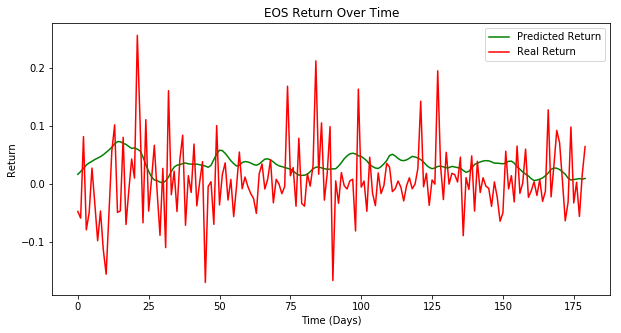

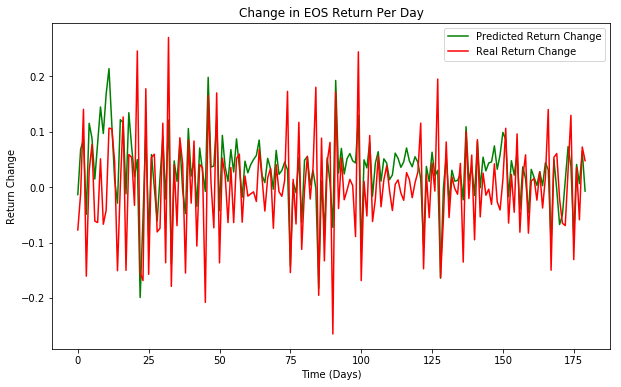

true positive is 89
false positive is 48
true negative is 38
false negative is 5
precision rate is 0.6496
accuracy rate is 0.7056
recall rate is 0.9468
F1 Score is 0.7706


In [3]:
#Compile together
#EOS 
#load the data 
X_train, Y_train, X_test, Y_test, window_length, dataset_total,Y_daybefore= load_data("merge_EOS-USD.csv", 50, 0.6768)
print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)
print(window_length)
print(Y_daybefore.shape)

#initialize the model
model = initialize_model(0.2)
print (model.summary())

#fit the model
model = fit_model(model, X_train, Y_train, 32, 100, .2)


#test the model and compare predicted return with real return
y_predict, real_y_test, real_y_predict, fig,real_y_daybefore =test_model(model, X_test, Y_test)

#return change per-day predicted vs real
return_change_predict, return_change_real, fig_2 = return_change(real_y_daybefore, real_y_test, real_y_predict)

#calculate confusion matrix
return_change_predict_1_0, return_change_real_1_0 = binary_return(return_change_predict,return_change_real)
true_pos, false_pos, true_neg, false_neg =  find_positives_negatives(return_change_predict_1_0, return_change_real_1_0)

print('true positive is',true_pos)
print('false positive is',false_pos)
print('true negative is',true_neg)
print('false negative is',false_neg)

precision = float(true_pos) / (true_pos + false_pos)
accuracy = float(true_pos+true_neg)/ (true_pos+true_neg+false_neg+false_pos)
recall=float(true_pos)/(true_pos+false_neg)
F1_score=2* (precision*recall)/(precision+recall)

print('precision rate is',round(precision,4))
print('accuracy rate is',round(accuracy,4))
print('recall rate is', round(recall,4))
print('F1 Score is',round(F1_score,4))

(2925, 40, 105)
(2925,)
(180, 40, 105)
(180,)
40
(180,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 40, 32)            17664     
_________________________________________________________________
dropout_4 (Dropout)          (None, 40, 32)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 40, 32)            1056      
_________________________________________________________________
lstm_5 (LSTM)                (None, 40, 32)            8320      
_________________________________________________________________
dropout_5 (Dropout)          (None, 40, 32)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 40, 32)            1056      
_________________________________________________________________
lstm_6 (LSTM)       

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:124: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 2340 samples, validate on 585 samples
Epoch 1/100
2340/2340 [==============================] - 34s 15ms/step - loss: 0.0024 - val_loss: 6.8908e-04
Epoch 2/100
2340/2340 [==============================] - 8s 3ms/step - loss: 8.4264e-04 - val_loss: 2.8650e-04
Epoch 3/100
2340/2340 [==============================] - 8s 3ms/step - loss: 7.6903e-04 - val_loss: 3.1561e-04
Epoch 4/100
2340/2340 [==============================] - 8s 3ms/step - loss: 7.5693e-04 - val_loss: 2.2841e-04
Epoch 5/100
2340/2340 [==============================] - 8s 4ms/step - loss: 7.2941e-04 - val_loss: 3.0668e-04
Epoch 6/100
2340/2340 [==============================] - 8s 4ms/step - loss: 7.1520e-04 - val_loss: 3.5184e-04
Epoch 7/100
2340/2340 [==============================] - 8s 4ms/step - loss: 7.1121e-04 - val_loss: 1.5299e-04
Epoch 8/100
2340/2340 [==============================] - 8s 4ms/step - loss: 6.9857e-04 - val_loss: 1.6452e-04
Epoch 9/100
2340/2340 [==============================] - 9s 4ms/ste

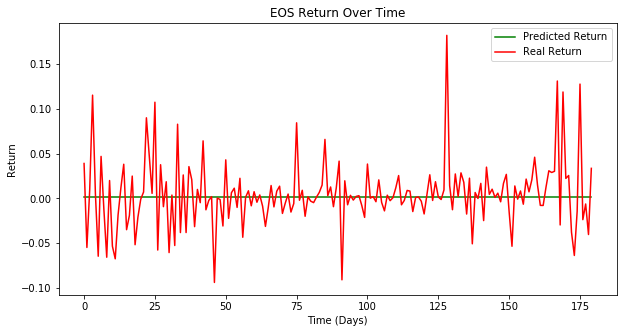

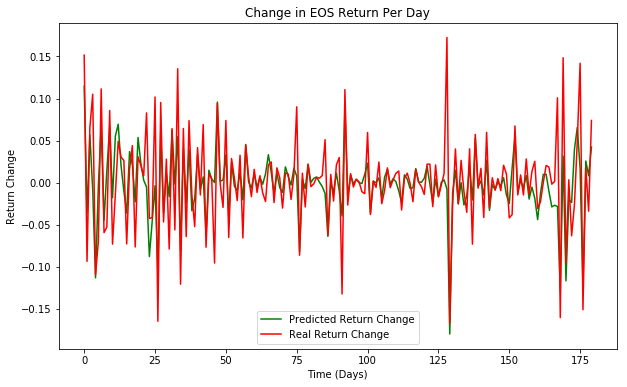

true positive is 73
false positive is 16
true negative is 68
false negative is 23
precision rate is 0.8202
accuracy rate is 0.7833
recall rate is 0.7604
F1 Score is 0.7892


In [4]:
#Compile together
#EOS 
#load the data 
X_train, Y_train, X_test, Y_test, window_length, dataset_total,Y_daybefore= load_data("Bitcoin.csv", 40, 0.942)
print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)
print(window_length)
print(Y_daybefore.shape)

#initialize the model
model = initialize_model(0.2)
print (model.summary())

#fit the model
model = fit_model(model, X_train, Y_train, 32, 100, .2)


#test the model and compare predicted return with real return
y_predict, real_y_test, real_y_predict, fig,real_y_daybefore =test_model(model, X_test, Y_test)

#return change per-day predicted vs real
return_change_predict, return_change_real, fig_2 = return_change(real_y_daybefore, real_y_test, real_y_predict)

#calculate confusion matrix
return_change_predict_1_0, return_change_real_1_0 = binary_return(return_change_predict,return_change_real)
true_pos, false_pos, true_neg, false_neg =  find_positives_negatives(return_change_predict_1_0, return_change_real_1_0)

print('true positive is',true_pos)
print('false positive is',false_pos)
print('true negative is',true_neg)
print('false negative is',false_neg)

precision = float(true_pos) / (true_pos + false_pos)
accuracy = float(true_pos+true_neg)/ (true_pos+true_neg+false_neg+false_pos)
recall=float(true_pos)/(true_pos+false_neg)
F1_score=2* (precision*recall)/(precision+recall)

print('precision rate is',round(precision,4))
print('accuracy rate is',round(accuracy,4))
print('recall rate is', round(recall,4))
print('F1 Score is',round(F1_score,4))

(2945, 20, 105)
(2945,)
(180, 20, 105)
(180,)
20
(180,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 20, 32)            17664     
_________________________________________________________________
dropout_7 (Dropout)          (None, 20, 32)            0         
_________________________________________________________________
dense_7 (Dense)              (None, 20, 32)            1056      
_________________________________________________________________
lstm_8 (LSTM)                (None, 20, 32)            8320      
_________________________________________________________________
dropout_8 (Dropout)          (None, 20, 32)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 20, 32)            1056      
_________________________________________________________________
lstm_9 (LSTM)       

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:124: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 2356 samples, validate on 589 samples
Epoch 1/100
2356/2356 [==============================] - 27s 11ms/step - loss: 0.0020 - val_loss: 2.4086e-04
Epoch 2/100
2356/2356 [==============================] - 5s 2ms/step - loss: 8.9443e-04 - val_loss: 3.6877e-04
Epoch 3/100
2356/2356 [==============================] - 5s 2ms/step - loss: 7.7879e-04 - val_loss: 2.8237e-04
Epoch 4/100
2356/2356 [==============================] - 4s 2ms/step - loss: 7.4441e-04 - val_loss: 2.1676e-04
Epoch 5/100
2356/2356 [==============================] - 5s 2ms/step - loss: 6.9559e-04 - val_loss: 1.7000e-04
Epoch 6/100
2356/2356 [==============================] - 4s 2ms/step - loss: 7.2074e-04 - val_loss: 1.6990e-04
Epoch 7/100
2356/2356 [==============================] - 4s 2ms/step - loss: 6.8583e-04 - val_loss: 1.8900e-04
Epoch 8/100
2356/2356 [==============================] - 4s 2ms/step - loss: 6.7841e-04 - val_loss: 1.9460e-04
Epoch 9/100
2356/2356 [==============================] - 4s 2ms/ste

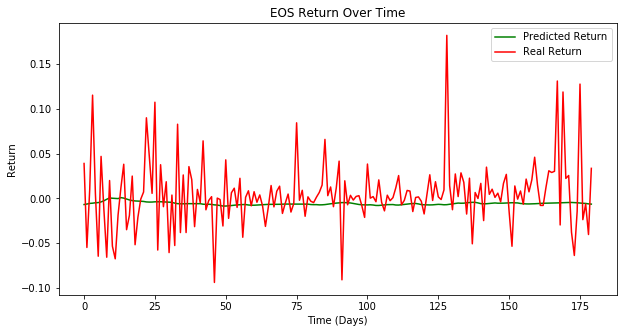

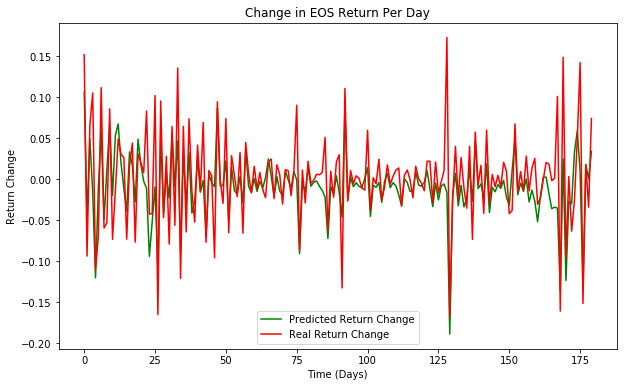

true positive is 50
false positive is 8
true negative is 76
false negative is 46
precision rate is 0.8621
accuracy rate is 0.7
recall rate is 0.5208
F1 Score is 0.6494


In [5]:
#Compile together
#EOS 
#load the data 
X_train, Y_train, X_test, Y_test, window_length, dataset_total,Y_daybefore= load_data("Bitcoin.csv", 20, 0.9424)
print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)
print(window_length)
print(Y_daybefore.shape)

#initialize the model
model = initialize_model(0.2)
print (model.summary())

#fit the model
model = fit_model(model, X_train, Y_train, 32, 100, .2)


#test the model and compare predicted return with real return
y_predict, real_y_test, real_y_predict, fig,real_y_daybefore =test_model(model, X_test, Y_test)

#return change per-day predicted vs real
return_change_predict, return_change_real, fig_2 = return_change(real_y_daybefore, real_y_test, real_y_predict)

#calculate confusion matrix
return_change_predict_1_0, return_change_real_1_0 = binary_return(return_change_predict,return_change_real)
true_pos, false_pos, true_neg, false_neg =  find_positives_negatives(return_change_predict_1_0, return_change_real_1_0)

print('true positive is',true_pos)
print('false positive is',false_pos)
print('true negative is',true_neg)
print('false negative is',false_neg)

precision = float(true_pos) / (true_pos + false_pos)
accuracy = float(true_pos+true_neg)/ (true_pos+true_neg+false_neg+false_pos)
recall=float(true_pos)/(true_pos+false_neg)
F1_score=2* (precision*recall)/(precision+recall)

print('precision rate is',round(precision,4))
print('accuracy rate is',round(accuracy,4))
print('recall rate is', round(recall,4))
print('F1 Score is',round(F1_score,4))

(2955, 10, 105)
(2955,)
(180, 10, 105)
(180,)
10
(180,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 10, 32)            17664     
_________________________________________________________________
dropout_22 (Dropout)         (None, 10, 32)            0         
_________________________________________________________________
dense_22 (Dense)             (None, 10, 32)            1056      
_________________________________________________________________
lstm_23 (LSTM)               (None, 10, 32)            8320      
_________________________________________________________________
dropout_23 (Dropout)         (None, 10, 32)            0         
_________________________________________________________________
dense_23 (Dense)             (None, 10, 32)            1056      
_________________________________________________________________
lstm_24 (LSTM)      

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:124: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 2364 samples, validate on 591 samples
Epoch 1/100
2364/2364 [==============================] - 5s 2ms/step - loss: 0.0018 - val_loss: 2.1665e-04
Epoch 2/100
2364/2364 [==============================] - 1s 382us/step - loss: 8.3481e-04 - val_loss: 1.9726e-04
Epoch 3/100
2364/2364 [==============================] - 1s 385us/step - loss: 7.9502e-04 - val_loss: 3.4651e-04
Epoch 4/100
2364/2364 [==============================] - 1s 387us/step - loss: 7.3699e-04 - val_loss: 1.8686e-04
Epoch 5/100
2364/2364 [==============================] - 1s 391us/step - loss: 7.2177e-04 - val_loss: 2.0315e-04
Epoch 6/100
2364/2364 [==============================] - 1s 388us/step - loss: 7.1438e-04 - val_loss: 1.7880e-04
Epoch 7/100
2364/2364 [==============================] - 1s 389us/step - loss: 6.8934e-04 - val_loss: 1.6615e-04
Epoch 8/100
2364/2364 [==============================] - 1s 401us/step - loss: 6.8344e-04 - val_loss: 1.6482e-04
Epoch 9/100
2364/2364 [==============================] 

2364/2364 [==============================] - 1s 399us/step - loss: 5.1926e-04 - val_loss: 1.5112e-04
Epoch 73/100
2364/2364 [==============================] - 1s 403us/step - loss: 6.0418e-04 - val_loss: 1.8785e-04
Epoch 74/100
2364/2364 [==============================] - 1s 400us/step - loss: 6.0436e-04 - val_loss: 1.5282e-04
Epoch 75/100
2364/2364 [==============================] - 1s 398us/step - loss: 6.0025e-04 - val_loss: 1.8052e-04
Epoch 76/100
2364/2364 [==============================] - 1s 401us/step - loss: 6.0724e-04 - val_loss: 1.5061e-04
Epoch 77/100
2364/2364 [==============================] - 1s 399us/step - loss: 5.9773e-04 - val_loss: 1.5054e-04
Epoch 78/100
2364/2364 [==============================] - 1s 397us/step - loss: 5.7257e-04 - val_loss: 1.5748e-04
Epoch 79/100
2364/2364 [==============================] - 1s 400us/step - loss: 5.9861e-04 - val_loss: 1.5977e-04
Epoch 80/100
2364/2364 [==============================] - 1s 399us/step - loss: 5.6429e-04 - val_loss

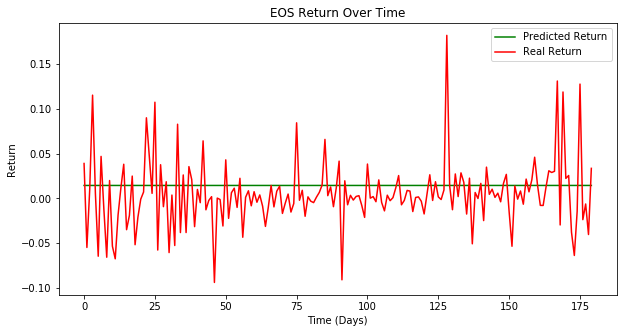

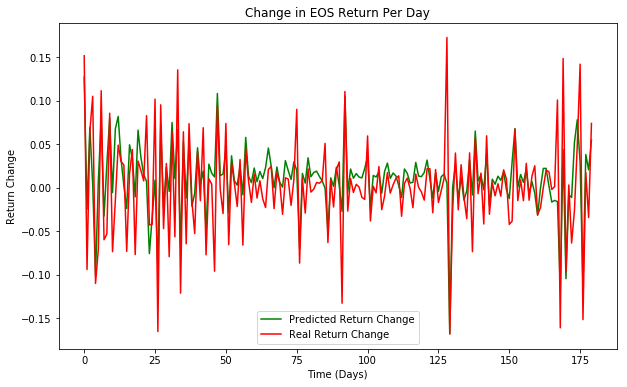

true positive is 90
false positive is 41
true negative is 43
false negative is 6
precision rate is 0.687
accuracy rate is 0.7389
recall rate is 0.9375
F1 Score is 0.793


In [10]:
#Compile together
#EOS 
#load the data 
X_train, Y_train, X_test, Y_test, window_length, dataset_total,Y_daybefore= load_data("Bitcoin.csv", 10, 0.9426)
print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)
print(window_length)
print(Y_daybefore.shape)

#initialize the model
model = initialize_model(0.2)
print (model.summary())

#fit the model
model = fit_model(model, X_train, Y_train, 32, 100, .2)


#test the model and compare predicted return with real return
y_predict, real_y_test, real_y_predict, fig,real_y_daybefore =test_model(model, X_test, Y_test)

#return change per-day predicted vs real
return_change_predict, return_change_real, fig_2 = return_change(real_y_daybefore, real_y_test, real_y_predict)

#calculate confusion matrix
return_change_predict_1_0, return_change_real_1_0 = binary_return(return_change_predict,return_change_real)
true_pos, false_pos, true_neg, false_neg =  find_positives_negatives(return_change_predict_1_0, return_change_real_1_0)

print('true positive is',true_pos)
print('false positive is',false_pos)
print('true negative is',true_neg)
print('false negative is',false_neg)

precision = float(true_pos) / (true_pos + false_pos)
accuracy = float(true_pos+true_neg)/ (true_pos+true_neg+false_neg+false_pos)
recall=float(true_pos)/(true_pos+false_neg)
F1_score=2* (precision*recall)/(precision+recall)

print('precision rate is',round(precision,4))
print('accuracy rate is',round(accuracy,4))
print('recall rate is', round(recall,4))
print('F1 Score is',round(F1_score,4))

(2865, 100, 105)
(2865,)
(180, 100, 105)
(180,)
100
(180,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 100, 32)           17664     
_________________________________________________________________
dropout_19 (Dropout)         (None, 100, 32)           0         
_________________________________________________________________
dense_19 (Dense)             (None, 100, 32)           1056      
_________________________________________________________________
lstm_20 (LSTM)               (None, 100, 32)           8320      
_________________________________________________________________
dropout_20 (Dropout)         (None, 100, 32)           0         
_________________________________________________________________
dense_20 (Dense)             (None, 100, 32)           1056      
_________________________________________________________________
lstm_21 (LSTM)   

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:124: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 2292 samples, validate on 573 samples
Epoch 1/100
2292/2292 [==============================] - 11s 5ms/step - loss: 0.0012 - val_loss: 1.8768e-04
Epoch 2/100
2292/2292 [==============================] - 7s 3ms/step - loss: 8.6522e-04 - val_loss: 3.2715e-04
Epoch 3/100
2292/2292 [==============================] - 8s 3ms/step - loss: 7.6733e-04 - val_loss: 2.2262e-04
Epoch 4/100
2292/2292 [==============================] - 8s 3ms/step - loss: 7.3623e-04 - val_loss: 2.0439e-04
Epoch 5/100
2292/2292 [==============================] - 7s 3ms/step - loss: 6.9658e-04 - val_loss: 2.2380e-04
Epoch 6/100
2292/2292 [==============================] - 7s 3ms/step - loss: 6.7954e-04 - val_loss: 1.9845e-04
Epoch 7/100
2292/2292 [==============================] - 7s 3ms/step - loss: 6.5695e-04 - val_loss: 1.8396e-04
Epoch 8/100
2292/2292 [==============================] - 7s 3ms/step - loss: 6.5658e-04 - val_loss: 1.9599e-04
Epoch 9/100
2292/2292 [==============================] - 8s 3ms/step

2292/2292 [==============================] - 7s 3ms/step - loss: 5.9200e-04 - val_loss: 1.5565e-04
Epoch 74/100
2292/2292 [==============================] - 7s 3ms/step - loss: 5.8375e-04 - val_loss: 1.5797e-04
Epoch 75/100
2292/2292 [==============================] - 7s 3ms/step - loss: 5.6066e-04 - val_loss: 1.5220e-04
Epoch 76/100
2292/2292 [==============================] - 7s 3ms/step - loss: 5.8614e-04 - val_loss: 1.5962e-04
Epoch 77/100
2292/2292 [==============================] - 7s 3ms/step - loss: 5.7282e-04 - val_loss: 1.6713e-04
Epoch 78/100
2292/2292 [==============================] - 7s 3ms/step - loss: 5.4811e-04 - val_loss: 1.5222e-04
Epoch 79/100
2292/2292 [==============================] - 7s 3ms/step - loss: 5.5845e-04 - val_loss: 1.5411e-04
Epoch 80/100
2292/2292 [==============================] - 7s 3ms/step - loss: 5.4844e-04 - val_loss: 1.6059e-04
Epoch 81/100
2292/2292 [==============================] - 7s 3ms/step - loss: 5.8332e-04 - val_loss: 1.5209e-04
Epoch

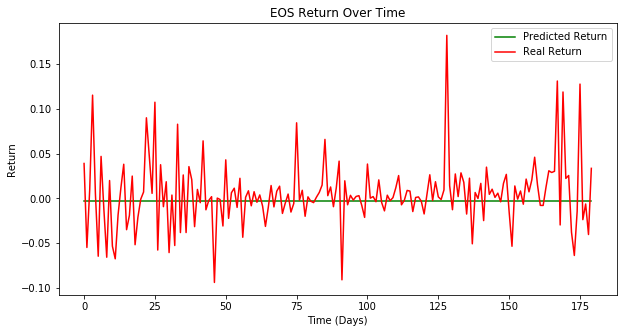

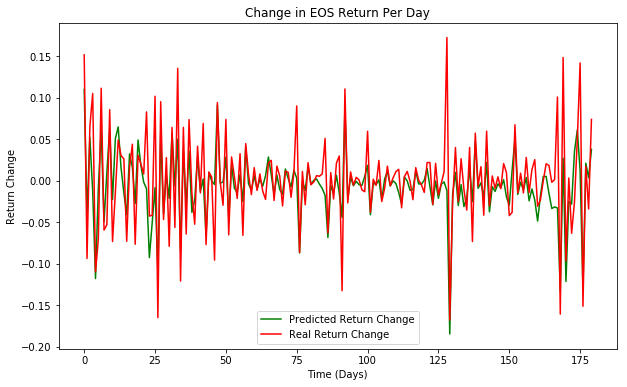

true positive is 57
false positive is 11
true negative is 73
false negative is 39
precision rate is 0.8382
accuracy rate is 0.7222
recall rate is 0.5938
F1 Score is 0.6951


In [9]:
#Compile together
#EOS 
#load the data 
X_train, Y_train, X_test, Y_test, window_length, dataset_total,Y_daybefore= load_data("Bitcoin.csv", 100, 0.9409)
print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)
print(window_length)
print(Y_daybefore.shape)

#initialize the model
model = initialize_model(0.2)
print (model.summary())

#fit the model
model = fit_model(model, X_train, Y_train, 32, 100, .2)


#test the model and compare predicted return with real return
y_predict, real_y_test, real_y_predict, fig,real_y_daybefore =test_model(model, X_test, Y_test)

#return change per-day predicted vs real
return_change_predict, return_change_real, fig_2 = return_change(real_y_daybefore, real_y_test, real_y_predict)

#calculate confusion matrix
return_change_predict_1_0, return_change_real_1_0 = binary_return(return_change_predict,return_change_real)
true_pos, false_pos, true_neg, false_neg =  find_positives_negatives(return_change_predict_1_0, return_change_real_1_0)

print('true positive is',true_pos)
print('false positive is',false_pos)
print('true negative is',true_neg)
print('false negative is',false_neg)

precision = float(true_pos) / (true_pos + false_pos)
accuracy = float(true_pos+true_neg)/ (true_pos+true_neg+false_neg+false_pos)
recall=float(true_pos)/(true_pos+false_neg)
F1_score=2* (precision*recall)/(precision+recall)

print('precision rate is',round(precision,4))
print('accuracy rate is',round(accuracy,4))
print('recall rate is', round(recall,4))
print('F1 Score is',round(F1_score,4))

(2785, 180, 105)
(2785,)
(180, 180, 105)
(180,)
180
(180,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 180, 32)           17664     
_________________________________________________________________
dropout_16 (Dropout)         (None, 180, 32)           0         
_________________________________________________________________
dense_16 (Dense)             (None, 180, 32)           1056      
_________________________________________________________________
lstm_17 (LSTM)               (None, 180, 32)           8320      
_________________________________________________________________
dropout_17 (Dropout)         (None, 180, 32)           0         
_________________________________________________________________
dense_17 (Dense)             (None, 180, 32)           1056      
_________________________________________________________________
lstm_18 (LSTM)   

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:124: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 2228 samples, validate on 557 samples
Epoch 1/100
2228/2228 [==============================] - 35s 16ms/step - loss: 0.0019 - val_loss: 2.5528e-04
Epoch 2/100
2228/2228 [==============================] - 29s 13ms/step - loss: 8.1328e-04 - val_loss: 1.8351e-04
Epoch 3/100
2228/2228 [==============================] - 29s 13ms/step - loss: 8.4124e-04 - val_loss: 1.7664e-04
Epoch 4/100
2228/2228 [==============================] - 28s 12ms/step - loss: 7.3594e-04 - val_loss: 2.9809e-04
Epoch 5/100
2228/2228 [==============================] - 27s 12ms/step - loss: 7.3393e-04 - val_loss: 2.0116e-04
Epoch 6/100
2228/2228 [==============================] - 26s 12ms/step - loss: 7.0650e-04 - val_loss: 2.6931e-04
Epoch 7/100
2228/2228 [==============================] - 26s 12ms/step - loss: 6.8606e-04 - val_loss: 2.3848e-04
Epoch 8/100
2228/2228 [==============================] - 26s 12ms/step - loss: 6.9824e-04 - val_loss: 4.1004e-04
Epoch 9/100
2228/2228 [==============================

Epoch 73/100
2228/2228 [==============================] - 14s 6ms/step - loss: 5.7344e-04 - val_loss: 1.5510e-04
Epoch 74/100
2228/2228 [==============================] - 14s 6ms/step - loss: 5.9942e-04 - val_loss: 1.5401e-04
Epoch 75/100
2228/2228 [==============================] - 14s 6ms/step - loss: 5.8073e-04 - val_loss: 1.6076e-04
Epoch 76/100
2228/2228 [==============================] - 15s 7ms/step - loss: 5.7386e-04 - val_loss: 1.5455e-04
Epoch 77/100
2228/2228 [==============================] - 15s 7ms/step - loss: 5.8191e-04 - val_loss: 1.7305e-04
Epoch 78/100
2228/2228 [==============================] - 16s 7ms/step - loss: 5.6469e-04 - val_loss: 1.9283e-04
Epoch 79/100
2228/2228 [==============================] - 15s 7ms/step - loss: 5.6118e-04 - val_loss: 1.6021e-04
Epoch 80/100
2228/2228 [==============================] - 14s 6ms/step - loss: 5.7012e-04 - val_loss: 1.5523e-04
Epoch 81/100
2228/2228 [==============================] - 14s 6ms/step - loss: 5.4546e-04 - val_

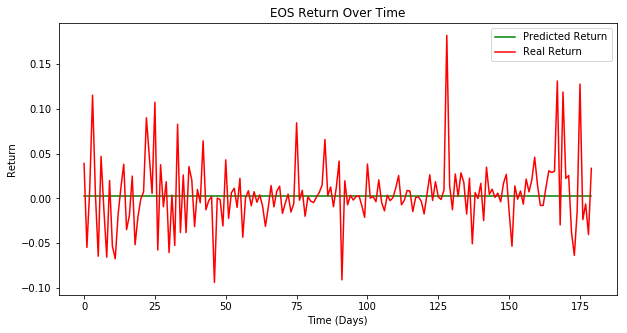

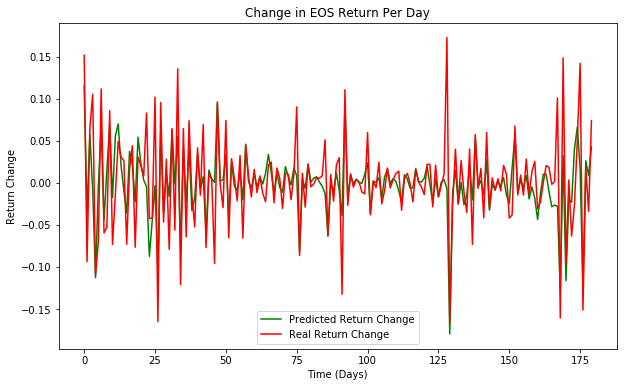

true positive is 75
false positive is 18
true negative is 66
false negative is 21
precision rate is 0.8065
accuracy rate is 0.7833
recall rate is 0.7812
F1 Score is 0.7937


In [8]:
#Compile together
#EOS 
#load the data 
X_train, Y_train, X_test, Y_test, window_length, dataset_total,Y_daybefore= load_data("Bitcoin.csv", 180, 0.9393)
print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)
print(window_length)
print(Y_daybefore.shape)

#initialize the model
model = initialize_model(0.2)
print (model.summary())

#fit the model
model = fit_model(model, X_train, Y_train, 32, 100, .2)


#test the model and compare predicted return with real return
y_predict, real_y_test, real_y_predict, fig,real_y_daybefore =test_model(model, X_test, Y_test)

#return change per-day predicted vs real
return_change_predict, return_change_real, fig_2 = return_change(real_y_daybefore, real_y_test, real_y_predict)

#calculate confusion matrix
return_change_predict_1_0, return_change_real_1_0 = binary_return(return_change_predict,return_change_real)
true_pos, false_pos, true_neg, false_neg =  find_positives_negatives(return_change_predict_1_0, return_change_real_1_0)

print('true positive is',true_pos)
print('false positive is',false_pos)
print('true negative is',true_neg)
print('false negative is',false_neg)

precision = float(true_pos) / (true_pos + false_pos)
accuracy = float(true_pos+true_neg)/ (true_pos+true_neg+false_neg+false_pos)
recall=float(true_pos)/(true_pos+false_neg)
F1_score=2* (precision*recall)/(precision+recall)

print('precision rate is',round(precision,4))
print('accuracy rate is',round(accuracy,4))
print('recall rate is', round(recall,4))
print('F1 Score is',round(F1_score,4))